In [69]:
from common_func import *
if type_of_script() == 'jupyter': from tqdm.notebook import tqdm
else: from tqdm import tqdm
    
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import colormaps
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D, proj3d
#import cmasher as cmr

import numpy as np
import os, glob, atexit, signal, time, warnings, argparse, subprocess

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=1

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle

from importlib import reload
from copy import deepcopy
from multiprocessing import Pool, shared_memory, Value

In [70]:
mode1 = 'nh'
iout1 = 1026
repo, rurmode, dp = mode2repo(mode1)
nh1 = uri.RamsesSnapshot(repo, iout1, mode=rurmode)
nh1s = uri.TimeSeries(nh1)
nh1s.read_iout_avail()
nout1 = nh1s.iout_avail['iout']
gals1 = uhmi.HaloMaker.load(nh1, galaxy=True, double_precision=dp)
hals1 = uhmi.HaloMaker.load(nh1, galaxy=False, double_precision=dp)
database1 = f"/home/jeon/MissingSat/database"

mode2 = 'nh2'
iout2 = 797
repo, rurmode, dp = mode2repo(mode2)
nh2 = uri.RamsesSnapshot(repo, iout2, mode=rurmode)
nh2s = uri.TimeSeries(nh2)
nh2s.read_iout_avail()
nout2 = nh2s.iout_avail['iout']
gals2 = uhmi.HaloMaker.load(nh2, galaxy=True, double_precision=dp)
hals2 = uhmi.HaloMaker.load(nh2, galaxy=False, double_precision=dp)
database2 = f"/home/jeon/MissingSat/database/nh2"

[Output 01026] Age (Gyr) : 11.624 / 13.741, z = 0.17149 (a = 0.8536)
[Output 00797] Age (Gyr) : 11.623 / 13.741, z = 0.17158 (a = 0.8536)


# Sample Selection

# MWA

In [71]:
LG1 = pklload(f"{database1}/LG")
LG2 = pklload(f"{database2}/LG")
old1 = pklload(f"{database}/old/befo231031/03_MWA1s.pickle")
old1[8]['m200'] = LG1[11]['BGG']['m200']
old2 = pklload(f"{database}/old/befo231031/03_MWA2s.pickle")
keys1 = []
for key in LG1.keys():
    if(LG1[key]['isLG']): keys1.append(key)
keys2 = []
for key in LG2.keys():
    if(LG2[key]['isLG']): keys2.append(key)

In [72]:
MWmass = 6.08e10; dMW = (7.22-4.94)/2 * 10**10
sm1 = MWmass-2*dMW; sm2 = MWmass+2*dMW
LGmass = 3.4e12; dLG = (4.8-2.3)/2 * 10**12
lm1 = LGmass-2*dLG; lm2 = LGmass+2*dLG

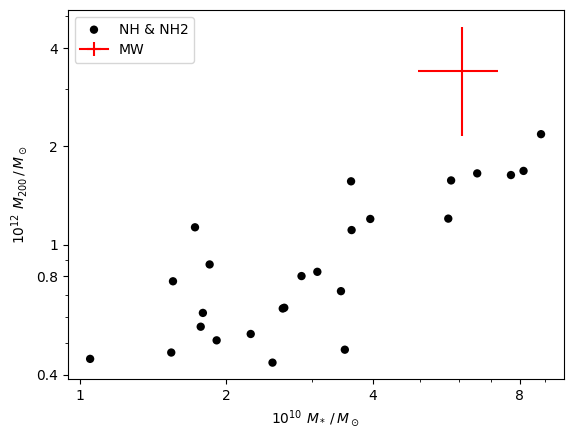

In [73]:
fig, ax = plt.subplots()

tmp = old1[ (old1['m']>1e10) & (old1['m200']>1e11)]
mask = isin(tmp['id'], keys1)
ax.scatter(tmp[mask]['m'], tmp[mask]['m200'], fc='k', ec='none', label='NH & NH2')
tmp = old2[ (old2['m']>1e10) & (old2['m200']>1e11)]
mask = isin(tmp['id'], keys2)
ax.scatter(tmp[mask]['m'], tmp[mask]['m200'], fc='k', ec='none')

ax.errorbar([6.08e10], [3.4e12], yerr=[1.25e12], xerr=[1.14e10],color='r', label='MW')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xticks([1e10, 2e10, 4e10, 8e10])
ax.set_xticklabels(["1", "2", "4", "8"])
ax.set_yticks([4e11, 8e11, 1e12, 2e12, 4e12])
ax.set_yticklabels(["0.4", "0.8", "1", "2", "4"])
ax.set_xlabel(r"$10^{10}\ M_*\,/\,M_\odot$")
ax.set_ylabel(r"$10^{12}\ M_{200}\,/\,M_\odot$")
ax.legend(loc='upper left')
plt.savefig(f"01_Mass_obs.png", dpi=400, facecolor='white', transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show(); plt.close()

## HaloMaker

In 3D plot, draw 2D density and levels

In [74]:
jump=os.path.exists(f"01_HaloMaker_3.png")

In [75]:
if(not jump):
    tmp = hals1[hals1['mcontam']==0]
    tmp = tmp[tmp['mvir'] < 1e12]
    tmp = tmp[np.argmax(tmp['mvir'])]
    print(np.log10(tmp['mvir']))
    nh1.set_box_halo(tmp, radius=1, radius_name='r')
    nh1.get_part(pname='dm', nthread=16, target_fields=['x','y','z','m'])
    print(nh1.part.shape)
    members = hals1[hals1['host'] == tmp['id']]
    print( np.unique(members['level'], return_counts=True) )

In [76]:
from matplotlib.colors import LightSource
import mpl_toolkits.mplot3d.art3d as art3d

if(not jump):
    ls = LightSource(azdeg=-45, altdeg=30)
    nbin = 240
    xbins = np.linspace(nh1.box[0][0], nh1.box[0][1], nbin+1)
    ybins = np.linspace(nh1.box[1][0], nh1.box[1][1], nbin+1)
    bins = [xbins, ybins]


    for i in range(4):
        if(os.path.exists(f"01_HaloMaker_{i}.png")): continue
        fig, ax = plt.subplots(1,1, figsize=(4,8), dpi=200, subplot_kw={'projection':'3d', 'box_aspect':(0.6, 0.6, 1),"computed_zorder":False})
        plt.subplots_adjust(wspace=0, hspace=0)
        if(i==0):
            raw, xe, ye = np.histogram2d(nh1.part['x'], nh1.part['y'], bins=bins, weights=nh1.part['m','Msol'])
            xx,yy = np.meshgrid(0.5*(xe[1:]+xe[:-1]), 0.5*(ye[1:]+ye[:-1]))
            ax.set_title(f"All", color='w')
            drawhals = members
        elif(i==1):
            parts = uhmi.HaloMaker.read_member_part(nh1, tmp['id'], galaxy=False)
            raw, xe, ye = np.histogram2d(parts['x'], parts['y'], bins=bins, weights=parts['m','Msol'])
            ax.set_title(f"level {i}", color='w')
            drawhals = [tmp]
        else:
            ihals = members[members['level'] == i]
            parts = uhmi.HaloMaker.read_member_parts(nh1, ihals, galaxy=False, nthread=8)
            raw, xe, ye = np.histogram2d(parts['x'], parts['y'], bins=bins, weights=parts['m','Msol'])
            ax.set_title(f"level {i}", color='w')
            drawhals = members[members['level'] == i]
        hist = gaussian_filter(raw, sigma=2)
        raw = gaussian_filter(raw, sigma=1)
        amin = np.min(hist[hist>0])
        if(i==0):
            vmin = np.log10(np.min(hist[hist>0]))
            vmax = np.log10(np.max(hist))
        else:
            vmin -= 0.5
        hist[hist==0] = amin/2
        lhist = np.log10(hist)
        
        if(i>-1):
            rgb = ls.shade(lhist, plt.get_cmap("inferno"), vmin=vmin, vmax=vmax)
            lhist[lhist<vmin] = np.nan
            ax.plot_surface(xx, yy, lhist, rstride=1, cstride=1, lw=0, facecolors=rgb, antialiased=False, zorder=6)
            ax.set_zlim(vmin-1.5,vmax)
            ax.contourf(xx, yy, np.log10(raw.T), levels=30, zdir='z', offset=vmin-1.51, cmap='inferno', zorder=4, vmin=vmin, vmax=vmax)
        for drawhal in drawhals:
            cir = circle(drawhal, rname='rvir', zorder=5, color='cyan', lw=0.5)
            ax.add_patch(cir)
            art3d.pathpatch_2d_to_3d(cir, z=vmin-1.5, zdir="z")

        ax.set_xlim(xe[0], xe[-1])
        ax.set_ylim(ye[0], ye[-1])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        
        ax.set_axis_off()
        plt.savefig(f"01_HaloMaker_{i}.png", dpi=400, facecolor='none', transparent=True, bbox_inches='tight', pad_inches=0.1)
        print(f"`00_HaloMaker_{i}.png` done")
        plt.close()

## Local Group

In [77]:
LG1 = pklload(f"{database1}/LG")
LG2 = pklload(f"{database2}/LG")
jump=os.path.exists(f"01_MWA_3.png")
jump=False

In [78]:
if(not jump):
    key=1; MWA = LG1[1]
    BGG = MWA['BGG']
    sats = MWA['sats']
    subs = MWA['subs']
    real = MWA['real']
    star = pklload(f"{database1}/parts/nh_star_{key:04d}.pickle")
    dm = pklload(f"{database1}/parts/nh_dm_{key:04d}.pickle")
    cell = pklload(f"{database1}/parts/nh_cell_{key:04d}.pickle")
    nh1.box = MWA['box']
    star = uri.Particle(star,nh1)
    dm = uri.Particle(dm,nh1)
    cell = uri.Cell(cell,nh1)

In [82]:
from common_func import _ibox
ibox = _ibox(BGG, factor=1.5, rname='r200_code')
if(not jump):
    rband = measure_luminosity(star, 'SDSS_r')
    starmap = painter.partmap(star, box=ibox, weights=rband, shape=1080)
    dmmap_raw = painter.partmap(dm, box=ibox, shape=1080)
    dmmap = gaussian_filter(dmmap_raw, sigma=3)
    # instar = cut_sphere(star, BGG['x'], BGG['y'], BGG['z'], BGG['r']/3)
    # irband = measure_luminosity(instar, 'SDSS_r')
    # instarmap = painter.partmap(instar, box=ibox, weights=irband, shape=1080)

    mask = cell['T','K'] < 5e4
    cellmap = painter.gasmap(cell[~mask], box=ibox, shape=1080)
    coldmap = painter.gasmap(cell[mask], box=ibox, shape=1080)

Computing particle map of 7815248 particles... 
Done (2.745s).
Computing particle map of 1444269 particles... 
Done (0.177s).
MinLvl = 12, MaxLvl = 18, Initial Image Size:  [1280 1280]
Drawing gas map... 
Done (3.981s).
MinLvl = 13, MaxLvl = 18, Initial Image Size:  [1248 1216]
Drawing gas map... 
Done (2.233s).


In [83]:
import cmasher as cmr
if(not jump):
    cmap_star = drawer.make_cmap([(0,0,0),(1,0,0),(1,1,0),(1,1,1)], position=[0,0.4,0.8,1])
    cmap_dm = drawer.make_cmap([(0,0,0),(0.1,0.25,0.15),(0,0.5,0)], position=[0,0.5,1])
    # cmap_cell = cmr.neutral
    cmap_cell = cmr.dusk
    # cmap_cold = cmr.arctic
    cmap_cold = drawer.make_cmap(
            [[0,0,0], [2/255,2/255,25/255], [25/255, 25/255, 132/255], [25/255, 191/255, 255/255], [222/255, 222/255, 255/255]], 
            position=[0, 0.15, 0.35,0.85,1])
    comp1 = painter.composite_image(
        [starmap, coldmap], 
        cmaps=[cmap_star, cmap_cold],
        qscales=[4,5],
        mode='average',
        vmaxs = [np.nanmax(starmap)*0.9, np.nanmax(coldmap)],
        weights=[1,1]
        )
    comp2 = painter.composite_image(
        [cellmap, dmmap], 
        cmaps=[cmap_cell, cmap_dm],
        qscales=[4,3.5],
        mode='average',
        vmaxs = [np.nanmax(cellmap)*10, np.nanmax(dmmap)*5],
        weights=[1,4]
        )

### A. Pure Image

In [92]:
if(not os.path.exists("01_MWA_0.png"))or(not jump):
    fig, axes = fancy_axes(ncols=2, figsize=(16,8), dpi=200,)
    ax = axes[0]
    ax.imshow(comp1, origin='lower', extent=ibox[:2].flatten(), aspect='equal')
    cir = plt.Circle((BGG['x'], BGG['y']), BGG['r200_code'], color='w', fill=False, lw=0.5, ls=':', zorder=10)
    ax.add_patch(cir)
    cir = plt.Circle((BGG['x'], BGG['y']), 1.5*BGG['r200_code'], color='w', fill=False, lw=0.5, ls=':', zorder=10)
    ax.add_patch(cir)
    # ax_inset = ax.inset_axes([0.75,0.75,0.24,0.24])
    # istarimg = cmap_star(painter.norm(instarmap, None, None, qscale=4, mode='log'))
    # ax_inset.imshow(istarimg, origin='lower', extent=ibox[:2].flatten(), aspect='equal')
    # ax_inset.spines['bottom'].set_color('white')
    # ax_inset.spines['top'].set_color('white')
    # ax_inset.spines['left'].set_color('white')
    # ax_inset.spines['right'].set_color('white')
    # ax_inset.set_xticks([]); ax_inset.set_yticks([])
    # ax_inset.set_xticklabels([]); ax_inset.set_yticklabels([])

    add_scalebar(ax, nh1.unit_l)
    # addtext(f"Milky Way Analog",ax=ax, loc='upper left', color='white', fontsize=12, offset=0.025, family='serif')
    ax.text(0.5, 0.05, "Star & Cold Gas", ha='center', va='center', color='white', fontsize=12, family='serif', transform=ax.transAxes)
    ax = axes[1]
    ax.imshow(comp2, origin='lower', extent=ibox[:2].flatten(), aspect='equal')
    cir = plt.Circle((BGG['x'], BGG['y']), BGG['r200_code'], color='w', fill=False, lw=0.5, ls=':', zorder=10)
    ax.add_patch(cir)
    cir = plt.Circle((BGG['x'], BGG['y']), 1.5*BGG['r200_code'], color='w', fill=False, lw=0.5, ls=':', zorder=10)
    ax.add_patch(cir)

    add_scalebar(ax, nh1.unit_l)
    # addtext(f"Local Group Analog",ax=ax, loc='upper left', color='white', fontsize=12, offset=0.025, family='serif')
    ax.text(0.5, 0.05, "DM & Hot Gas", ha='center', va='center', color='white', fontsize=12, family='serif', transform=ax.transAxes)
    plt.savefig(f"01_MWA_0.png", dpi=400, transparent=False, facecolor='none', bbox_inches='tight', pad_inches=0)
    plt.close()

### B. HaloMaker Image

In [86]:
virials1 = pklload(f"{database1}/merged_to_LG/virial_radius_nh_1026.pickle")
dtype1 = hals1.dtype
dtype2 = virials1.dtype
dtype = np.dtype(dtype1.descr + dtype2.descr)
nhals1 = np.zeros(hals1.shape, dtype=dtype)
for iname in tqdm(hals1.dtype.names):
    nhals1[iname] = hals1[iname]
for iname in tqdm(virials1.dtype.names):
    nhals1[iname] = virials1[iname]

virials2 = pklload(f"{database2}/virial_radius_nh2_797.pickle")
dtype1 = hals2.dtype
dtype2 = virials2.dtype
dtype = np.dtype(dtype1.descr + dtype2.descr)
nhals2 = np.zeros(hals2.shape, dtype=dtype)
for iname in tqdm(hals2.dtype.names):
    nhals2[iname] = hals2[iname]
for iname in tqdm(virials2.dtype.names):
    nhals2[iname] = virials2[iname]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [93]:
from matplotlib.lines import Line2D
if(not os.path.exists("01_MWA_1.png"))or(not jump):
    hs = cut_sphere(nhals1, BGG['x'], BGG['y'], BGG['z'], 1.5*BGG['r200_code'], both_sphere=True, rname='r200')
    hs = hs[hs['id'] != BGG['halo_id']]

    radii = 1.5*BGG['r200_code']
    radii = max(radii, np.max(distance(hs, BGG)+hs['r200']))

    gs = cut_sphere(gals1, BGG['x'], BGG['y'], BGG['z'], radii, both_sphere=True, rname='r')
    gs = gs[gs['id'] != BGG['id']]


    fig, axes = fancy_axes(ncols=2, figsize=(16,8), dpi=200,)
    ax = axes[0]
    ax.imshow(comp1, origin='lower', extent=ibox[:2].flatten(), aspect='equal')
    cir = plt.Circle((BGG['x'], BGG['y']), BGG['r200_code'], color='w', fill=False, lw=0.5, ls=':', zorder=10)
    ax.add_artist(cir)
    cir = plt.Circle((BGG['x'], BGG['y']), 1.5*BGG['r200_code'], color='w', fill=False, lw=0.5, ls=':', zorder=10)
    ax.add_artist(cir)
    # ax_inset = ax.inset_axes([0.75,0.75,0.24,0.24])
    # istarimg = cmap_star(painter.norm(instarmap, None, None, qscale=4, mode='log'))
    # ax_inset.imshow(istarimg, origin='lower', extent=ibox[:2].flatten(), aspect='equal')
    # ax_inset.spines['bottom'].set_color('white')
    # ax_inset.spines['top'].set_color('white')
    # ax_inset.spines['left'].set_color('white')
    # ax_inset.spines['right'].set_color('white')
    # ax_inset.set_xticks([]); ax_inset.set_yticks([])
    # ax_inset.set_xticklabels([]); ax_inset.set_yticklabels([])

    for g in gs:
        cir = circle(g, rname='r', zorder=5, color='cyan', lw=0.5)
        ax.add_artist(cir)
    label=fr"$N_{{satellite}}={len(gs)}$"
    legend_circle = Line2D([0], [0], marker='o', color='cyan', label=label, lw=0,
                        markersize=15, mfc='none', mec='cyan')
    leg = ax.legend(loc='lower left', handles=[legend_circle], frameon=False)
    for text in leg.get_texts():
        text.set_color('cyan')

    add_scalebar(ax, nh1.unit_l)
    # addtext(f"Milky Way Analog",ax=ax, loc='upper left', color='white', fontsize=12, offset=0.025, family='serif')
    ax.text(0.5, 0.05, "Star & Cold Gas", ha='center', va='center', color='white', fontsize=12, family='serif', transform=ax.transAxes)
    ax = axes[1]
    ax.imshow(comp2, origin='lower', extent=ibox[:2].flatten(), aspect='equal')
    cir = plt.Circle((BGG['x'], BGG['y']), BGG['r200_code'], color='w', fill=False, lw=0.5, ls=':', zorder=10)
    ax.add_artist(cir)
    cir = plt.Circle((BGG['x'], BGG['y']), 1.5*BGG['r200_code'], color='w', fill=False, lw=0.5, ls=':', zorder=10)
    ax.add_artist(cir)

    for h in hs:
        cir = circle(h, rname='rvir', zorder=5, color='magenta', lw=0.5)
        ax.add_artist(cir)
    label=fr"$N_{{subhalo}}={len(hs)}$"
    legend_circle = Line2D([0], [0], marker='o', color='magenta', label=label, lw=0,
                        markersize=15, mfc='none', mec='magenta')
    leg = ax.legend(loc='lower left', handles=[legend_circle], frameon=False)
    for text in leg.get_texts():
        text.set_color('magenta')

    add_scalebar(ax, nh1.unit_l)
    # addtext(f"Local Group Analog",ax=ax, loc='upper left', color='white', fontsize=12, offset=0.025, family='serif')
    ax.text(0.5, 0.05, "DM & Hot Gas", ha='center', va='center', color='white', fontsize=12, family='serif', transform=ax.transAxes)
    plt.savefig(f"01_MWA_1.png", dpi=400, transparent=False, facecolor='none', bbox_inches='tight', pad_inches=0)
    plt.close()

### C. Remove non-reals

In [94]:
from matplotlib.lines import Line2D
if(not os.path.exists("01_MWA_2.png"))or(not jump):
    ohs = cut_sphere(nhals1, BGG['x'], BGG['y'], BGG['z'], 1.5*BGG['r200_code'], both_sphere=True, rname='r200')
    ohs = ohs[ohs['id'] != BGG['halo_id']]
    hs = ohs[isin(ohs['id'], real['hid'])]

    radii = 1.5*BGG['r200_code']
    radii = max(radii, np.max(distance(hs, BGG)+hs['r200']))

    ogs = cut_sphere(gals1, BGG['x'], BGG['y'], BGG['z'], radii, both_sphere=True, rname='r')
    ogs = ogs[ogs['id'] != BGG['id']]
    gs = ogs[isin(ogs['id'], real['gid'])]


    fig, axes = fancy_axes(ncols=2, figsize=(16,8), dpi=200,)
    ax = axes[0]
    ax.imshow(comp1, origin='lower', extent=ibox[:2].flatten(), aspect='equal')
    cir = plt.Circle((BGG['x'], BGG['y']), BGG['r200_code'], color='w', fill=False, lw=0.5, ls=':', zorder=10)
    ax.add_artist(cir)
    cir = plt.Circle((BGG['x'], BGG['y']), 1.5*BGG['r200_code'], color='w', fill=False, lw=0.5, ls=':', zorder=10)
    ax.add_artist(cir)
    # ax_inset = ax.inset_axes([0.75,0.75,0.24,0.24])
    # istarimg = cmap_star(painter.norm(instarmap, None, None, qscale=4, mode='log'))
    # ax_inset.imshow(istarimg, origin='lower', extent=ibox[:2].flatten(), aspect='equal')
    # ax_inset.spines['bottom'].set_color('white')
    # ax_inset.spines['top'].set_color('white')
    # ax_inset.spines['left'].set_color('white')
    # ax_inset.spines['right'].set_color('white')
    # ax_inset.set_xticks([]); ax_inset.set_yticks([])
    # ax_inset.set_xticklabels([]); ax_inset.set_yticklabels([])

    for g in gs:
        cir = circle(g, rname='r', zorder=5, color='cyan', lw=0.5)
        ax.add_artist(cir)
    label=fr"$N_{{satellite}}={len(ogs)}\to{len(gs)}$"
    legend_circle = Line2D([0], [0], marker='o', color='cyan', label=label, lw=0,
                        markersize=15, mfc='none', mec='cyan')
    leg = ax.legend(loc='lower left', handles=[legend_circle], frameon=False)
    for text in leg.get_texts():
        text.set_color('cyan')


    add_scalebar(ax, nh1.unit_l)
    # addtext(f"Milky Way Analog",ax=ax, loc='upper left', color='white', fontsize=12, offset=0.025, family='serif')
    ax.text(0.5, 0.05, "Star & Cold Gas", ha='center', va='center', color='white', fontsize=12, family='serif', transform=ax.transAxes)
    ax = axes[1]
    ax.imshow(comp2, origin='lower', extent=ibox[:2].flatten(), aspect='equal')
    cir = plt.Circle((BGG['x'], BGG['y']), BGG['r200_code'], color='w', fill=False, lw=0.5, ls=':', zorder=10)
    ax.add_artist(cir)
    cir = plt.Circle((BGG['x'], BGG['y']), 1.5*BGG['r200_code'], color='w', fill=False, lw=0.5, ls=':', zorder=10)
    ax.add_artist(cir)

    for h in hs:
        cir = circle(h, rname='rvir', zorder=5, color='magenta', lw=0.5)
        ax.add_artist(cir)
    label=fr"$N_{{subhalo}}={len(ohs)}\to{len(hs)}$"
    legend_circle = Line2D([0], [0], marker='o', color='magenta', label=label, lw=0,
                        markersize=15, mfc='none', mec='magenta')
    leg = ax.legend(loc='lower left', handles=[legend_circle], frameon=False)
    for text in leg.get_texts():
        text.set_color('magenta')

    add_scalebar(ax, nh1.unit_l)
    # addtext(f"Local Group Analog",ax=ax, loc='upper left', color='white', fontsize=12, offset=0.025, family='serif')
    ax.text(0.5, 0.05, "DM & Hot Gas", ha='center', va='center', color='white', fontsize=12, family='serif', transform=ax.transAxes)
    plt.savefig(f"01_MWA_2.png", dpi=400, transparent=False, facecolor='none', bbox_inches='tight', pad_inches=0)
    plt.close()

### D. Classify

In [88]:
from matplotlib.lines import Line2D
if(not os.path.exists("01_MWA_3.png"))or(not jump):
    ohs = cut_sphere(nhals1, BGG['x'], BGG['y'], BGG['z'], 1.5*BGG['r200_code'], both_sphere=True, rname='r200')
    ohs = ohs[ohs['id'] != BGG['halo_id']]
    hs = ohs[isin(ohs['id'], real['hid'])]

    radii = 1.5*BGG['r200_code']
    radii = max(radii, np.max(distance(hs, BGG)+hs['r200']))

    ogs = cut_sphere(gals1, BGG['x'], BGG['y'], BGG['z'], radii, both_sphere=True, rname='r')
    ogs = ogs[ogs['id'] != BGG['id']]
    gs = ogs[isin(ogs['id'], real['gid'])]




    fig, axes = fancy_axes(ncols=2, figsize=(16,8), dpi=200,)
    ax = axes[0]
    ax.imshow(comp1, origin='lower', extent=ibox[:2].flatten(), aspect='equal')
    cir = plt.Circle((BGG['x'], BGG['y']), BGG['r200_code'], color='w', fill=False, lw=0.5, ls=':', zorder=10)
    ax.add_artist(cir)
    cir = plt.Circle((BGG['x'], BGG['y']), 1.5*BGG['r200_code'], color='w', fill=False, lw=0.5, ls=':', zorder=10)
    ax.add_artist(cir)
    # ax_inset = ax.inset_axes([0.75,0.75,0.24,0.24])
    # istarimg = cmap_star(painter.norm(instarmap, None, None, qscale=4, mode='log'))
    # ax_inset.imshow(istarimg, origin='lower', extent=ibox[:2].flatten(), aspect='equal')
    # ax_inset.spines['bottom'].set_color('white')
    # ax_inset.spines['top'].set_color('white')
    # ax_inset.spines['left'].set_color('white')
    # ax_inset.spines['right'].set_color('white')
    # ax_inset.set_xticks([]); ax_inset.set_yticks([])
    # ax_inset.set_xticklabels([]); ax_inset.set_yticklabels([])

    for g in gs:
        arg = np.where(g['id'] == real['gid'])[0][0]
        color='white' if(real['state'][arg]=='pair') else 'cyan'
        cir = circle(g, rname='r', zorder=5, color=color, lw=0.5)
        ax.add_artist(cir)
    udgs = sats[sats['id'] < 0]
    # for g in udgs:
    #     cir = circle(g, rname='r', zorder=5, color='yellow', lw=0.5, ls=':')
    #     ax.add_artist(cir)
    npair = np.sum( (real['state']=='pair')&isin(real['gid'], gs['id']) )
    label=fr"$N_{{sat,pair}}={npair}$"
    pair_circle = Line2D([0], [0], marker='o', color='white', label=label, lw=0,
                        markersize=15, mfc='none', mec='white')
    label=fr"$N_{{sat,orphan}}={len(gs)-npair}$"
    orphan_circle = Line2D([0], [0], marker='o', color='cyan', label=label, lw=0,
                        markersize=15, mfc='none', mec='cyan')
    # label=fr"$N_{{sat,UDG}}={len(udgs)}$"
    # UDG_circle = Line2D([0], [0], marker='o', color='yellow', label=label, lw=0,
    #                     markersize=15, mfc='none', mec='yellow')
    leg = ax.legend(loc='lower left', handles=[pair_circle,orphan_circle], frameon=False)
    for text, eline in zip(leg.get_texts(), leg.get_lines()):
        text.set_color(eline.get_color())


    add_scalebar(ax, nh1.unit_l)
    # addtext(f"Milky Way Analog",ax=ax, loc='upper left', color='white', fontsize=12, offset=0.025, family='serif')
    ax.text(0.5, 0.05, "Star & Cold Gas", ha='center', va='center', color='white', fontsize=12, family='serif', transform=ax.transAxes)
    ax = axes[1]
    ax.imshow(comp2, origin='lower', extent=ibox[:2].flatten(), aspect='equal')
    cir = plt.Circle((BGG['x'], BGG['y']), BGG['r200_code'], color='w', fill=False, lw=0.5, ls=':', zorder=10)
    ax.add_artist(cir)
    cir = plt.Circle((BGG['x'], BGG['y']), 1.5*BGG['r200_code'], color='w', fill=False, lw=0.5, ls=':', zorder=10)
    ax.add_artist(cir)

    udgs = real[real['state']=='upair']['hid']
    for h in hs:
        if(h['id'] in udgs): continue
        arg = np.where(h['id'] == real['hid'])[0][0]
        color='white' if(real['state'][arg]=='pair') else 'magenta'
        cir = circle(h, rname='rvir', zorder=5, color=color, lw=0.5)
        ax.add_artist(cir)
    # for ih in udgs:
    #     h = hals1[ih-1]
    #     cir = circle(h, rname='rvir', zorder=5, color='yellow', lw=0.5, ls=':')
    #     ax.add_artist(cir)
    npair = np.sum( (real['state']=='pair')&isin(real['hid'], hs['id']) )
    label=fr"$N_{{sub,pair}}={npair}$"
    pair_circle = Line2D([0], [0], marker='o', color='white', label=label, lw=0,
                        markersize=15, mfc='none', mec='white')
    label=fr"$N_{{sub,dink}}={len(hs)-npair-len(udgs)}$"
    dink_circle = Line2D([0], [0], marker='o', color='magenta', label=label, lw=0,
                        markersize=15, mfc='none', mec='magenta')
    # label=fr"$N_{{sub,UDG}}={len(udgs)}$"
    # UDG_circle = Line2D([0], [0], marker='o', color='yellow', label=label, lw=0,
    #                     markersize=15, mfc='none', mec='yellow')
    leg = ax.legend(loc='lower left', handles=[pair_circle,dink_circle], frameon=False)
    for text, eline in zip(leg.get_texts(), leg.get_lines()):
        text.set_color(eline.get_color())

    add_scalebar(ax, nh1.unit_l)
    # addtext(f"Local Group Analog",ax=ax, loc='upper left', color='white', fontsize=12, offset=0.025, family='serif')
    ax.text(0.5, 0.05, "DM & Hot Gas", ha='center', va='center', color='white', fontsize=12, family='serif', transform=ax.transAxes)
    plt.savefig(f"01_MWA_3.png", dpi=400, transparent=False, facecolor='none', bbox_inches='tight', pad_inches=0)
    plt.close()

## Numbers

In [15]:
keys = []
pairgs = None; pairhs = None; dinkhs = None; upairgs = None; upairhs = None; orphans = None
for key in LG1.keys():
    if(LG1[key]['isLG']):
        keys.append(key)
        sats = LG1[key]['sats']
        subs = LG1[key]['subs']
        real = LG1[key]['real']

        tmp = sats[isin(sats['id'], real[real['state']=='pair']['gid'])]
        pairgs = tmp if(pairgs is None) else np.hstack((pairgs, tmp))
        tmp = subs[isin(subs['id'], real[real['state']=='pair']['hid'])]
        pairhs = tmp if(pairhs is None) else np.hstack((pairhs, tmp))
        tmp = subs[isin(subs['id'], real[real['state']=='dink']['hid'])]
        dinkhs = tmp if(dinkhs is None) else np.hstack((dinkhs, tmp))
        tmp = sats[isin(sats['id'], real[real['state']=='orphan']['gid'])]
        orphans = tmp if(orphans is None) else np.hstack((orphans, tmp))
        tmp = sats[isin(sats['id'], real[real['state']=='upair']['gid'])]
        upairgs = tmp if(upairgs is None) else np.hstack((upairgs, tmp))
        tmp = subs[isin(subs['id'], real[real['state']=='upair']['hid'])]
        upairhs = tmp if(upairhs is None) else np.hstack((upairhs, tmp))

print(keys, len(keys))
print(len(pairgs), len(pairhs), len(dinkhs), len(orphans), len(upairgs), len(upairhs))

[1, 3, 7, 8, 10, 23, 25, 26, 36, 64, 121, 129, 11] 13
130 130 1145 83 61 61


In [16]:
keys = []
pairgs = None; pairhs = None; dinkhs = None; upairgs = None; upairhs = None; orphans = None
for key in LG2.keys():
    if(LG2[key]['isLG']):
        keys.append(key)
        sats = LG2[key]['sats']
        subs = LG2[key]['subs']
        real = LG2[key]['real']

        tmp = sats[isin(sats['id'], real[real['state']=='pair']['gid'])]
        pairgs = tmp if(pairgs is None) else np.hstack((pairgs, tmp))
        tmp = subs[isin(subs['id'], real[real['state']=='pair']['hid'])]
        pairhs = tmp if(pairhs is None) else np.hstack((pairhs, tmp))
        tmp = subs[isin(subs['id'], real[real['state']=='dink']['hid'])]
        dinkhs = tmp if(dinkhs is None) else np.hstack((dinkhs, tmp))
        tmp = sats[isin(sats['id'], real[real['state']=='orphan']['gid'])]
        orphans = tmp if(orphans is None) else np.hstack((orphans, tmp))
        tmp = sats[isin(sats['id'], real[real['state']=='upair']['gid'])]
        upairgs = tmp if(upairgs is None) else np.hstack((upairgs, tmp))
        tmp = subs[isin(subs['id'], real[real['state']=='upair']['hid'])]
        upairhs = tmp if(upairhs is None) else np.hstack((upairhs, tmp))

print(keys, len(keys))
print(len(pairgs), len(pairhs), len(dinkhs), len(orphans), len(upairgs), len(upairhs))

[2, 12, 45, 14, 3, 19, 18, 25, 37, 131, 143, 89, 10] 13
79 79 1120 33 43 43
